In [124]:
import numpy as np
import matplotlib.pyplot as plt

/var/folders/xv/w6vjg90x4pd72d9mbrnc1v6h0000gn/T/ipykernel_1912/2244603848.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


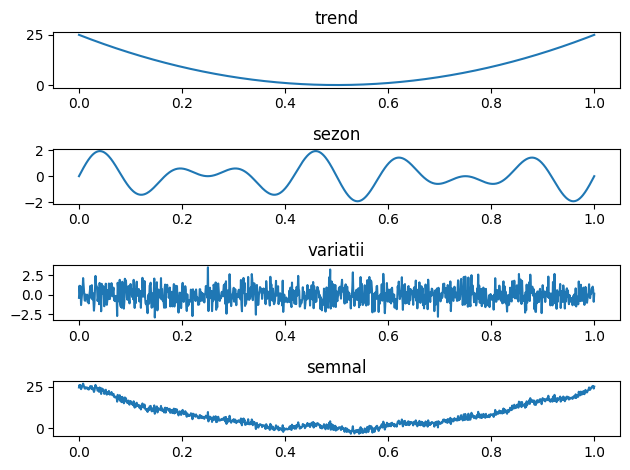

In [125]:
# a)

trend = lambda x : 100 * (x - 0.5) ** 2
sezon = lambda x: np.sin(2 * np.pi * 5 * x) + np.sin(2 * np.pi * 7 * x)
variatii = lambda x:  np.random.normal(0,1,len(x))

N = 1000
time = np.linspace(0, 1, N)
t = trend(time)
s = sezon(time)
v = variatii(time)

signal = t + s + v 

fig, axs = plt.subplots(4)
axs[0].plot(time, t)
axs[0].set_title("trend")
axs[1].plot(time, s)
axs[1].set_title("sezon")
axs[2].plot(time, v)
axs[2].set_title("variatii")
axs[3].plot(time, signal)
axs[3].set_title("semnal")

fig.savefig("ex1_a.pdf")
fig.tight_layout()
fig.show()



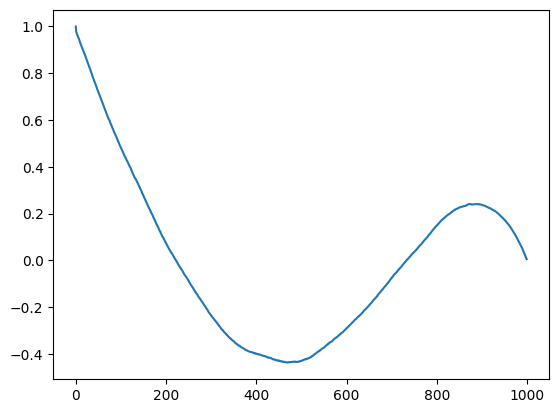

In [126]:
# b)

signalAltered = (signal - np.mean(signal)) / (np.std(signal))
correlation_vector = np.correlate(signalAltered, signalAltered, mode="full") 
correlation_vector = correlation_vector[correlation_vector.size // 2:] / N

plt.plot(correlation_vector)
plt.savefig("ex1_b.pdf")
plt.show()

/var/folders/xv/w6vjg90x4pd72d9mbrnc1v6h0000gn/T/ipykernel_1912/2979243028.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


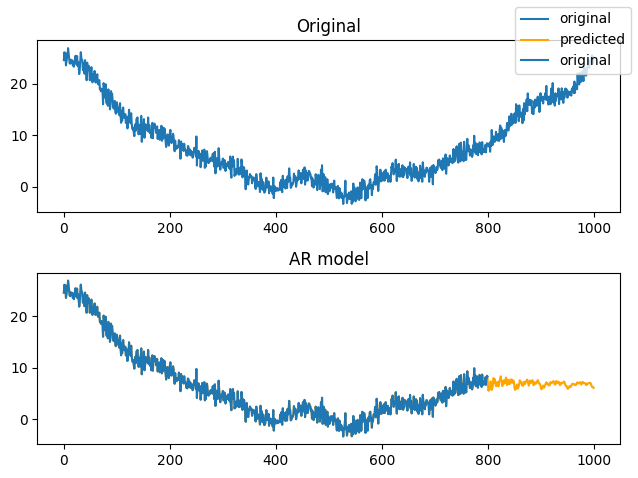

In [127]:
# c)

def train(trainSignal, p):
    Y =  trainSignal[p - 1 : trainSignal.size - 1]
    for i in range(2, p + 1):
        shifted = trainSignal[p - i : trainSignal.size - i]
        Y = np.column_stack((Y, shifted))
    
    Y = np.column_stack((Y, np.zeros(len(Y))))
    x_star = np.linalg.lstsq(Y, trainSignal[p:], rcond=None)[0]
    x_star = x_star[ : -1]
    
    return x_star

def trainOptimized(trainSignal, p):
    signalAltered = (trainSignal - np.mean(trainSignal)) / (np.std(trainSignal))
    correlation_vector = np.correlate(signalAltered, signalAltered, mode="full") 
    correlation_vector = correlation_vector[correlation_vector.size // 2:] / len(signalAltered)
    correlation_vector = correlation_vector[ : p + 1]
    
    gammaMatrix = np.zeros((correlation_vector.size - 1, correlation_vector.size - 1))
    for i in range(len(gammaMatrix)):
        for j in range(len(gammaMatrix)):
            gammaMatrix[i , j] = correlation_vector[abs(i - j)]
    
    x_star = np.linalg.lstsq(gammaMatrix, correlation_vector[1:], rcond=None)[0]
    
    return x_star
    
    

def predict(trainSignal, predictionsNeeded, p, x_star):
    result = trainSignal.copy()
    for _ in range(predictionsNeeded):    
        y_pred = x_star.T @ result[-p : ]
        result = np.append(result, y_pred)
    
    return result

def mse(predictions, labels):
    mse = np.sum((predictions - labels) ** 2) / len(predictions)
    return mse
    
    

foldSize = 800
p = 50
trainSignal = signal[: foldSize]
testSignal = signal[foldSize:]

x_star = trainOptimized(trainSignal, p)

# x_star = train(trainSignal, p)
predictions = predict(trainSignal, len(testSignal), p, x_star)

fig, axs = plt.subplots(2)
axs[0].plot(signal, label="original")
axs[0].set_title("Original")
axs[1].plot(predictions, label="predicted", color="orange")
axs[1].plot(trainSignal, label="original")
axs[1].set_title("AR model")

fig.legend()
fig.tight_layout()
fig.savefig("ex1_c.pdf")
fig.show()
        

In [ ]:
# d)

def crossValidation(signal):
    
    bestMse = np.Inf
    bestParams = None
    for p in range(100, 800, 100):
        for m in range(p, N, 100):
            folds = 0
            mse_cv = 0
            for start in range(0, N - m, 1):
                trainSignal = signal[start: start + m + 1]
                x_star = trainOptimized(trainSignal, p)
                predictions = predict(trainSignal, 1, p, x_star)
                predictions = predictions[predictions.size - 1 : predictions.size]
                
                mse_test = mse(predictions, signal[start + m + 1 : start + m + 2])
                mse_cv += mse_test ** 2
                folds += 1
            
            mse_cv /= folds
            if mse_cv < bestMse:
                bestMse = mse_cv
                bestParams = (p, m)
                
    return bestParams
                
            

                

p, m = crossValidation(signal)
print("p=", p)
print("m=",m)